In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Our report is organized in such a way, that at each section, we first import the results from the computations made by the functions in *utilities.py*.

A summarized explanation on how we computed these results then immediately follows after importing them.

For detailed commentary on the code steps, refer to the corresponding functions in utilities.py."

# Data Understanding

## 1. Exploratory Data Analysis

- Examination and understanding of the dataset's structure and content.
- Performing exploratory data analysis to understand data patterns, outliers, and relationships between variables.

Summary of the Data Exploration:  

There are many redundancies in the data. The business_entity_doing_business_as_name uniquely defines the compset_group,  the list of compsets, legal_entity_name, domicile_country_name, ultimate_parent_legal_entity_name and primary_exchange_name. Additionally there are duplicate rows only differing in the compset. 

To remove redundancies and format the data in a suitable way for further analysis we created a clean_data function. The functionality of the function is described below:

We checked in Data_Cleaning_js.ipynb that the column names listed above do not change over time for any business_entity_doing_business_as_name. There are also no NaNs in business_entity_doing_business_as_name, this column can therefore be interpreted as keys, defining the other entries in the other columns listed above. We therefore extract these meta-information into a different data-frame called df_brands.

Additionally the summary rows with compset='All Brands' are extracted to a data-frame df_allbrands.

The main df now contains only the period_end_date, business_entity_doing_business_as_name and the five numerical quantities. Additionally a list of brands, compsets, compset_groups is provided


In [3]:
from utilities import clean_data

In [4]:
df, df_brands, df_allbrands, brands, compsets, compset_groups, groups_bycompset = clean_data()

### Heatmap

Implementing a heatmap to determine which correlations are noteworthy

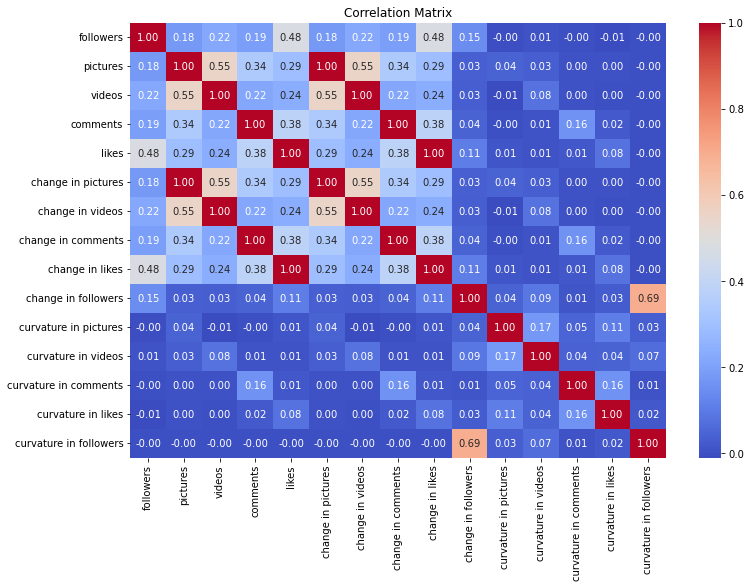

In [16]:
from utilities import derivatives_data
df_rate, df_curvature = derivatives_data(df)

corr_mat = df.corr()
corr_mat_rate = df_rate.corr()
corr_mat_curv = df_curvature.corr()

import seaborn as sns

df_concatenated = pd.concat([df, df_rate, df_curvature], axis=1)

# Compute the correlation matrix
correlation_matrix = df_concatenated.corr()

# Plot the heatmaps
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

We can see a significant correlation in the change of followers and the curvature of the followers data.
In a mathematical sense, if f(t) is the number of followers for a given time t, this correlation somewhat corresponds to the relation
f'(t) ~ f''(t)
where f'(t) and f''(t) denote the first and second time derivative respectively, and ~ is the sign for proportionality.
this differential equation can be solved, revealing the solution for f(t) = f(0)*exp(c*t), where c is a constant.
The correlation coefficient of 0.69 shows tendencies towards exponential growth of follower numbers for the companies in many cases.

## 2. Data Cleaning

### Handling Missing Values

In [5]:
from utilities import missing_df, missing_values

In order to get a feeling of the distribution and magnitude of the missing values, we created a new datafram *missing_df* containing the total number of entries per business and the total number of missing values per business per category.

In [6]:
missing_df = missing_df(df)

print(missing_df.shape)
missing_df.head()

(705, 7)


,Business,Total Entries:,Missing followers:,Missing pictures:,Missing videos:,Missing comments:,Missing likes:
0,24S,333,20,1,1,1,1
1,3.1 Phillip Lim,455,18,0,0,0,0
2,3CE,455,131,0,0,0,0
3,A. Lange & Soehne,403,8,3,2,2,2
4,ANIMALE,403,131,0,2,0,0


In the function *missing_values()*, we reorganized the DataFrame *df* by date and business, revealing numerous initial missing-value-series across many businesses. By removing these initial series, we reduced the number of rows containing at least one missing value from 65,868 to 4,378.

By identifying the lengths and locations of all remaining missing-value-series in the data, we manage to further decrease the number of rows containing at least one missing value to 4,145. This represents a $ 94 \% $ decrease in rows containing at least one missing value.

In [7]:
cleaned_df = missing_values(df)

Number of rows with at least one NaN before cleaning: 65868
Number of rows with at least one NaN after dropping series of Nan's at beginning of businesses: 4378

 Remaining number of rows with Nan that are not at beginning or end:
Number of rows with 4 NaNs: 3214
Number of rows with 3 NaNs: 0
Number of rows with 2 NaNs: 7
Number of rows with 1 NaNs: 924
Total remaining rows with at least one Nan:  4145

 Total number of rows after cleaning: 236317


Based on the following facts:
- Most of the remaining missing values were are all series of lengths greater than 20, spread randomly through the data.
- There were only 4,145 of the total of 236,317 rows left that contained at least one missing value.

We made the following **assumption**:
- We assumed that the remaining missing values would not affect the performance of our model significantly.

Based on that we decided to leave the remaining missing values for now, and check after implementing the model wether our assumption was correct.

 

### Normalization

In [8]:
from utilities import normalization

The Normalization function is a useful tool when building ML models that work off the number of followers, likes, etc. It Easily scales the Data Frame down by many orders of magnitude.
For example, the number of 'likes' for 'Pepsi' is transformed into its ratio of total likes across all companies, given by the 'likes' from 'All Brands (Study)'

We added it to our utilities since it can be applied in many instances and for easy access

### Computing Derivatives

In [9]:
from utilities import derivatives_data

In [10]:
df_rate, df_curvature = derivatives_data(df)

In the context of wanting to predict outliers and deviations, it is useful to look at time derivatives, gradients etc...
Since the time resolution is fixed at weekly intervals, the derivative of our numerical data will be proportional to simply its difference from one week to the next. From this basic idea we built a function "derivatives_data" which computes two dataframes:
- df_rate_of_change: this contains the first time derivative (slope) of all parameters 'followers', 'likes' ...
- df_curvature     : this contains the second time derivative (curvature) of all parameters 'followers', 'likes' ...

# Modeling Approach

## 1. Feature Engineering

- Feature engineering to create relevant features for identifying deviations.

### Ranking the followers

By grouping the brands (business_entity_doing_business_as_name)

In [11]:
from utilities import ranking_followers
from scipy.signal import find_peaks
import math

In [12]:
cgroup_ranking, brands_by_cgroup = ranking_followers(df, df_brands, compset_groups)

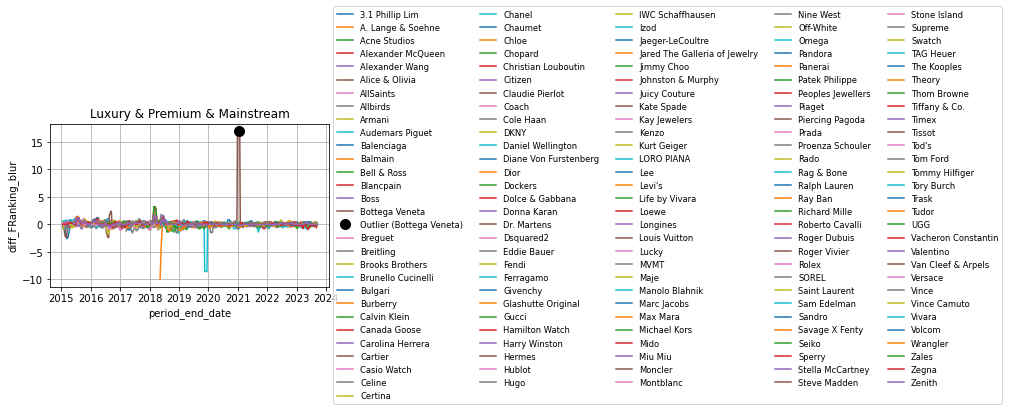

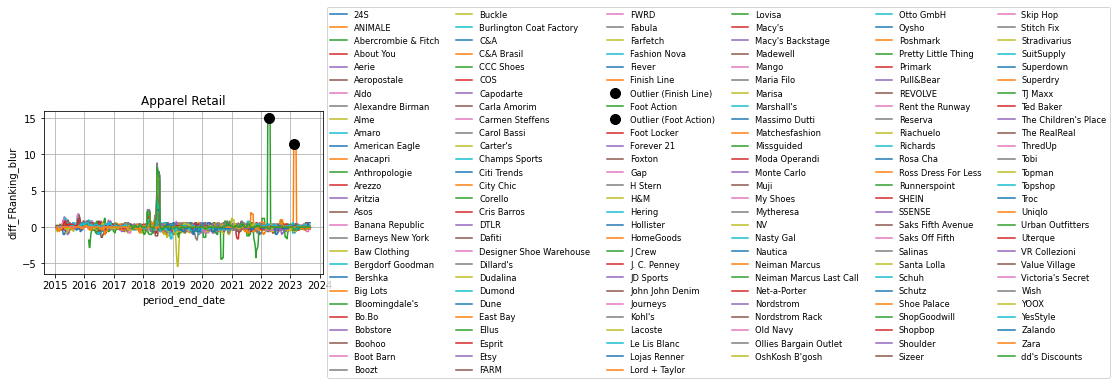

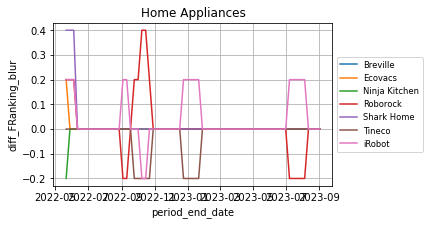

In [13]:
selection_of_cgroups=['Luxury & Premium & Mainstream', 'Apparel Retail','Home Appliances']

for cgroup in selection_of_cgroups:
    peaks = {}
    peak_height = {}
    peak_time = {}
    for brand, data in cgroup_ranking[cgroup].groupby('business_entity_doing_business_as_name'):
        peaks[brand], _ = find_peaks(list(data['diff_FRanking_blur']), height=2)
        peak_height[brand] = np.array(data['diff_FRanking_blur'])[peaks[brand]]
        peak_time[brand] = np.array(data['period_end_date'])[peaks[brand]]
        
    all=np.concatenate(list(peak_height.values()))
    threshold = 2

    plt.figure(figsize=(5,3))
    for brand, data in cgroup_ranking[cgroup].groupby('business_entity_doing_business_as_name'):
        plt.plot(data['period_end_date'], data['diff_FRanking_blur'], label=brand)
        if len(peak_time[brand])>0:
            z_scores = (peak_height[brand] - np.mean(all)) / np.std(all)
            if len(peak_time[brand][np.abs(z_scores) > threshold])>0:
                plt.plot(peak_time[brand][np.abs(z_scores) > threshold], peak_height[brand][np.abs(z_scores) > threshold], 'ko', markersize=10, label=f'Outlier ({brand})')
    plt.xlabel('period_end_date')
    plt.ylabel('diff_FRanking_blur')
    plt.title(cgroup)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small', ncol=math.ceil(len(brands_by_cgroup[cgroup])/30))
    plt.grid(True)
    plt.show()

### Correlation Analysis

Calculating the Correlation of different variables for different time shifts proved to be of significant help when trying to detect outliers. They Form a Metric for quantifying how much the data within one compset group deviates from the rest

In [14]:
import math
brands_by_cgroup = {} # dict: list of brands contained in each compset_group
for group in compset_groups:
    brands_by_cgroup[group] = df_brands[df_brands['compset_group'] == group][
        'business_entity_doing_business_as_name'].tolist()

cgroup_ranking = {cgroup: df_rate[df_rate['business_entity_doing_business_as_name'].isin(brands_by_cgroup[cgroup])] for cgroup in compset_groups}
compset_groups = df_brands['compset_group'].unique()

#initialize an array to save the correlation values
app_ret_correlation = []
df_corr = pd.DataFrame()
cgroup = 'Outdoor Gear' #in this example we look at companies producing Outdoor gear

for brand, data in cgroup_ranking[cgroup].groupby('business_entity_doing_business_as_name'):
    app_ret_correlation = []
    for lag in range(-8, 8):
        app_ret_correlation.append(data['change in likes'].corr(data['change in followers'].shift(lag)))
    
    # Create a temporary DataFrame for the current brand
    df_brand = pd.DataFrame({
        'correlation': app_ret_correlation,
        'lag': np.arange(-8, 8),
        'brand': brand
    })
    
    # Append the data for the current brand to the main DataFrame
    df_corr = pd.concat([df_corr, df_brand], ignore_index=True)

#normalize the curves by dividing by the mean correlation and looking whether the curve deviates significantly by 1
df_corr_normalized = df_corr.copy()
# Calculate the mean correlation for each lag across all companies
mean_corrs = df_corr.groupby('lag')['correlation'].mean()
# Normalize and shift the correlation values for each company
for brand in df_corr_normalized['brand'].unique():
    for lag in df_corr_normalized['lag'].unique():
        # Normalize the correlation values by the mean correlation for the lag across all companies
        df_corr_normalized.loc[(df_corr_normalized['lag'] == lag) & (df_corr_normalized['brand'] == brand), 'correlation'] /= mean_corrs[lag]
    # Shift the correlation values by their own mean to center them around y = 0
    df_corr_normalized.loc[df_corr_normalized['brand'] == brand, 'correlation'] -= df_corr_normalized.loc[df_corr_normalized['brand'] == brand, 'correlation'].mean()
    
from scipy.ndimage import gaussian_filter1d

sigma = 2
# Create a copy of the DataFrame for smoothed values
df_corr_smoothed = df_corr_normalized.copy()

# Smooth the correlation values for each brand separately
for brand in df_corr_normalized['brand'].unique():
    # Extract correlation values for the current brand
    brand_data = df_corr_normalized[df_corr_normalized['brand'] == brand]
    # Smooth the correlation values using Gaussian filter
    smoothed_values = gaussian_filter1d(brand_data['correlation'], sigma)
    # Update the DataFrame with the smoothed values
    df_corr_smoothed.loc[df_corr_smoothed['brand'] == brand, 'correlation'] = smoothed_values

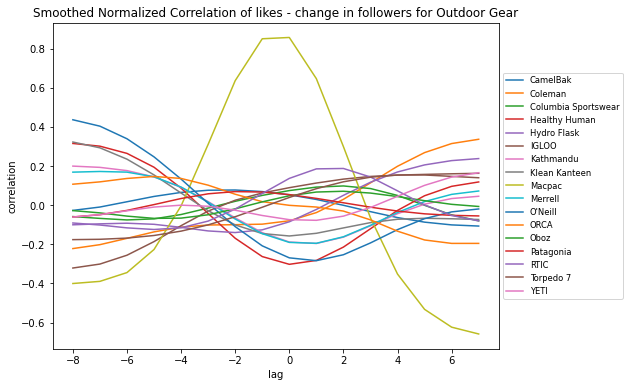

In [15]:
#the comparatevily strong correlation of company macpac around a lag of -1 indicates that for a week with strong likes, their followers increase in week + 1 predictably
plt.figure(figsize=(8,6))
for brand in df_corr_smoothed['brand'].unique():
    plt.plot(range(-8,8), df_corr_smoothed.loc[df_corr_smoothed['brand'] == brand, 'correlation'], label = brand)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small', ncol=math.ceil(len(brands_by_cgroup[cgroup])/30))
plt.title('Smoothed Normalized Correlation of likes - change in followers for Outdoor Gear')
plt.xlabel('lag')
plt.ylabel('correlation')
plt.show()

## 2. Development of Model

- Development of a model to identify significant deviations from observed trends.

## 3. Evaluation of Model

- Evaluation of the model's performance and its ability to identify deviations.

# Evaluation of Results

## 1. Analysis of deviations

- Analysis of deviations detected by your model, understanding potential causes.

## 2. Interpretation of the results

- Interpretation of the results, providing strategic insights based on deviations.

## 3. Use of alternative approaches

- Use of alternative approaches (potential enhancement of dataset with external data).